**OBJECTIVES:**

**1. Dimensionality Reduction for performance:** *Does PCA really helps ? ..in what ways? Does it improves training time, performance accuracy?*

**2. Dimensionality Reduction for Visualization:** *What are different Dimensionality Reduction methods for visualization and how better or worse are they in terms of speed and visualization.*
    
> *We will try to answer these questions by working around the MNIST dataset*

In [1]:
#importing python essential libraries, and our MNIST dataset.

import numpy as np
import pandas as pd
test = pd.read_csv("../input/mnist-data/mnist_test.csv")
train = pd.read_csv("../input/mnist-data/mnist_train.csv")

In [2]:
#separating the labels

y_train = train['label']
X_train = train.drop('label', axis = 1)

y_test = test['label']
X_test = test.drop('label', axis = 1)

In [3]:
#So, we have kept 60000 images for training and 10000 for testing
X_train.shape

(60000, 784)

**PCA compression**

*Let's compress our data using PCA Reduction and then decompress it again to see the 'loss' by plotting the actual image*

In [4]:
#let's first make the copy of our original training data before any transformations
X_train_ = X_train.copy()

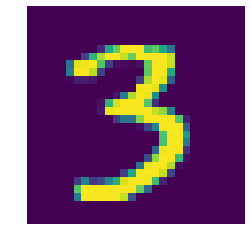

In [5]:
#Plotting a sample image

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(X_train.iloc[10000].to_numpy().reshape(28,28))
plt.axis('off')
plt.show()

In [6]:
#just to be assured!
y_train[10000]

3

In [7]:
#we will keep track of the time taken to perform each transformation and training.
import time

> Let's compress our data using PCA to a degree that preserves 95% variance of the data and only looses 5%.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
start = time.time()
X_reduced = pca.fit_transform(X_train)
end = time.time()

end - start

8.008251667022705

>PCA took 7 seconds to compress the data! Noted.

In [9]:
#so, only 154 out of 784 features can preserve 95% of the data, 
#this means the MNIST is originally very sparse and most of the data is rather present at a much lower dimension.  
pca.n_components_

154

>let's now reverse back the compression, using PCA reverse transform, While it reverses the dataset back to having 784 features
but the information lost(5%) due to compression never gets recovered. 

In [10]:
X_decompress = pca.inverse_transform(X_reduced)

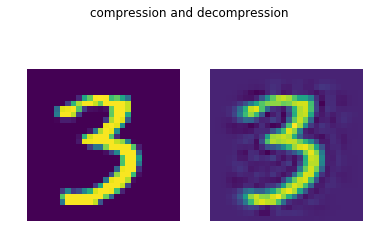

In [11]:
#now that we have got both compressed and decompressed data, let's plot them side by side to see how much we lost(5%)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(X_train.iloc[10000].to_numpy().reshape(28,28))
ax2.imshow(X_decompress[10000].reshape(28, 28))
fig.suptitle('compression and decompression')
ax1.axis('off')
ax2.axis('off')
plt.show()

So it seems that 5% loss(since we set preservance to 95%) was not a bad deal, the image still looks acceptable and we have significantly reduced the number of dimensions as well, from 784 to 154 trading for a 5% loss in image quality!

    1. Dimensionality Reduction for performance: Does PCA helps?

We have seen PCA helps in reducing the size of data upto a harmless level. Now, does this really helps in the training ? 
Does reduced number of dimensions helps in faster training ? Does reduced dataset generalize better or worse?

Lets try on a couple of classifiers to find the answers

**The Random Forest Classifier**

In [12]:
#classifier: Random Forest on Original data

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state = 42)
t0 = time.time()
rfc.fit(X_train_, y_train)
t1 = time.time()

t1-t0

57.3354115486145

In [13]:
#score on random forest
rfc.score(X_test, y_test)

0.9705

Random Forest took 59 sec to train the original data with 784 features and that gave a score of 97%!**

> Now let's check how does PCA the time and accuracy with Random Forest.

In [14]:
#classifier: Random Forest on Reduced data

rfc2 = RandomForestClassifier(n_estimators = 100, random_state = 42)
t0 = time.time()
rfc2.fit(X_reduced, y_train)
t1 = time.time()

t1-t0

119.6885678768158

In [15]:
#score of 'random forest' on Reduced data

X_test_reduced = pca.transform(X_test)
rfc2.score(X_test_reduced, y_test)

0.9481

**That's bad! Training took more than twice the time it took on original dataset. There is a drop in performance as well!
So PCA didn't really help in this case. But why did this happen?
Let's try this on one more classifier before concluding the observations.** 

**The Softmax Classifier**

In [16]:
#Classifier: Logistic Regression on Original data

from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state = 42)
t0 = time.time()
log_clf.fit(X_train_, y_train)
t1 = time.time()

t1-t0

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


22.24454355239868

In [17]:
#score of 'Logistic Regression' on Original data
log_clf.score(X_test, y_test)

0.9255

**Wait what! Softmax actually took half of the time taken by the Random Forest on the original dataset with a slight drop in performance. 
But our aim is to see what's tha case of PCA with the Softmax Classifier.**

In [18]:
#time to train on 'Logistic Regression' : Reduced data

log_clf2 = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state = 42)
t0 = time.time()
log_clf2.fit(X_reduced, y_train)
t1 = time.time()

t1-t0

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


10.947299242019653

*wow! Softmax Classifier is 2 times faster on reduced data than on original data. Let's check the model's accuracy as well *

In [19]:
#score of 'Logistic Regression' on Reduced data
log_clf2.score(X_test_reduced, y_test)

0.9201

**That's even great! Softmax Classifier trains faster on the reduced data with a extremely minimal drop in performance for 2x speed!**

> **Findings:** 
* We saw that PCA didn't help the Random Forest classifier, it instead made the training slow and worsened the performance of the classifier.
* While in case of Softmax Classifier, PCA helped it gain 2 times faster speed with almost similar performance.

> **Conclusions:**
* There you have it clearly, PCA helps..but not always
* Infact, Dimensionality Reduction does not always leads to faster training, it rather depends on the dataset, the model and the training algorithm used.

    2. Dimensionality Reduction for Visualization: Studying and comparing Visualizations using different methods of Reduction

**Using TSNE**

Since TSNE scales extremely slowly with large dataset, we will not use the full data, rather a sample of just 10000 instances for study purpose.

In [20]:
#creating random 10000 samples of the training data
X_train['label'] = y_train
X = X_train.sample(n=10000, random_state=42)

y = X['label']
X = X.drop('label', axis = 1)

In [21]:
#We will use TSNE to reduce the datset down to 2 Dimensions and then plot it using Matplotlib
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state = 42)
t0 = time.time()
X_reduced = tsne.fit_transform(X)
t1 = time.time()

t1-t0

284.9559979438782

Wuuf! it took almost 5 minutes for TSNE to compress the data(only with 10000 samples) to 2 dimensions. Now lets plot it.

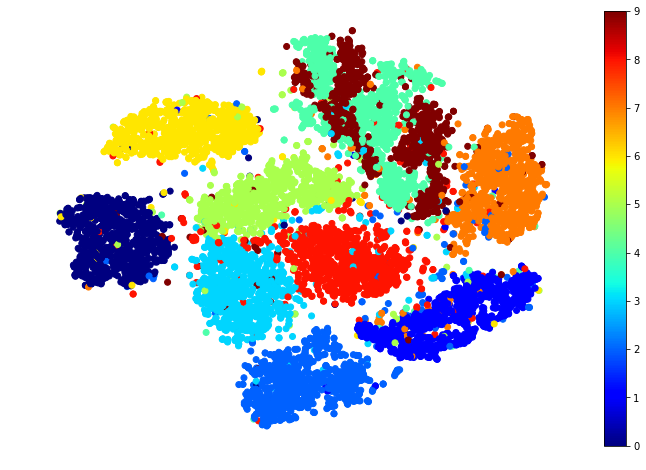

In [22]:
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c = y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

That looks quite nice! we can see clear separation of clusturs. 
while only a couple of these clusters seems to overlap, like 3s & 5s and 9s & 4s.
We can try to run PCA on select of them like 9s and 4s

In [23]:
idx = (y == 4) | (y == 9) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

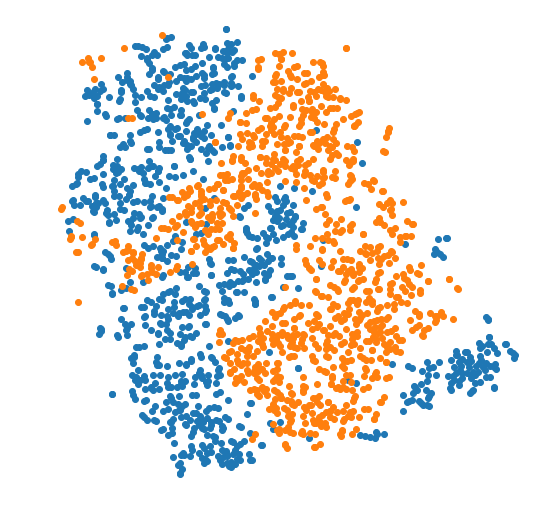

In [24]:
plt.figure(figsize=(9,9))
for digit in (4, 9):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1] )
plt.axis('off')
plt.show()

While they do not overlap as much, still the clusters are stuck together tightly!

Let's try some other visualization techiniques, let's go with PCA for visualization.

**PCA**

0.3151130676269531


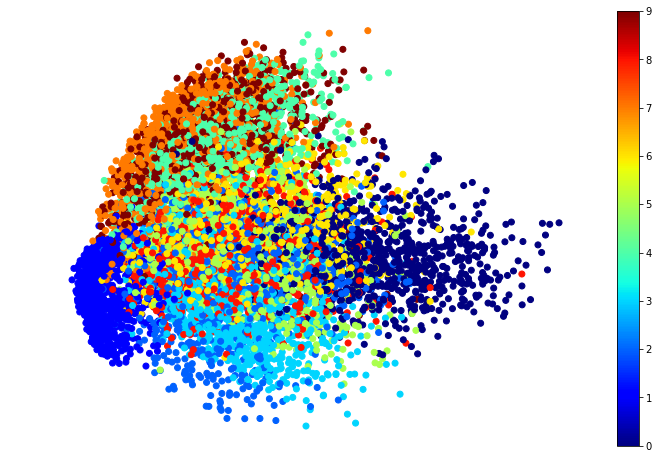

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
t0 = time.time()
X_pca = pca.fit_transform(X)
t1 = time.time()
print(t1-t0)

plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:,0], X_pca[:,1], c = y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

PCA is extremely fast! But we can clearly see how poor its visualization is. Almost everything is overlapped. 


What would happen if we combine PCA and TSNE? would that give any advantage? let's check it out

**PCA + TSNE**

150.07243490219116


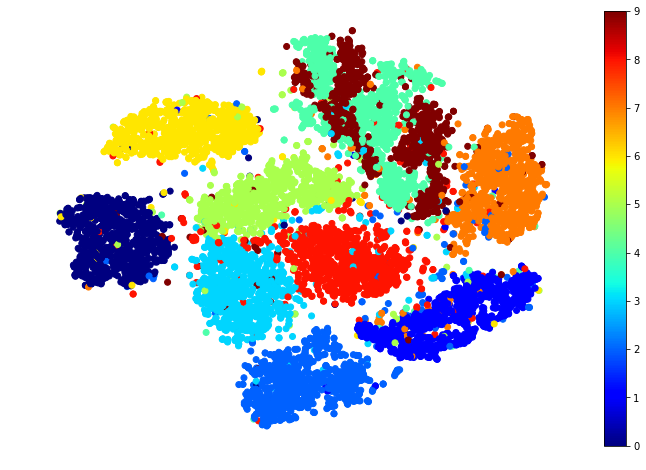

In [26]:
from sklearn.pipeline import Pipeline

pca_tsne = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('tsne', TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne = pca_tsne.fit_transform(X)
t1 = time.time()
print(t1-t0)

plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c = y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

*WOW! Did you notice what happened ? The result is quite exactly similar to that of using TSNE alone. But the time is reduced to about half of orginial time(just TSNE).*

*But how did that happen ?*

**Well, we already saw earlier that PCA is very fast compressor than others when it comes to large datasets, but algorithms like TSNE creats far better clusters than PCA, it make sense combining PCA(to quickly get rid of useless dimensions) and TSNE(a slower reduction algorithm reducing less heavy data to 2 Dimensions to make good clusters). This can significantly reduce the time.**

Let's now try on few other methods of dimensionality reduction

**LLE: Locally Linear Embedding**

206.3053421974182


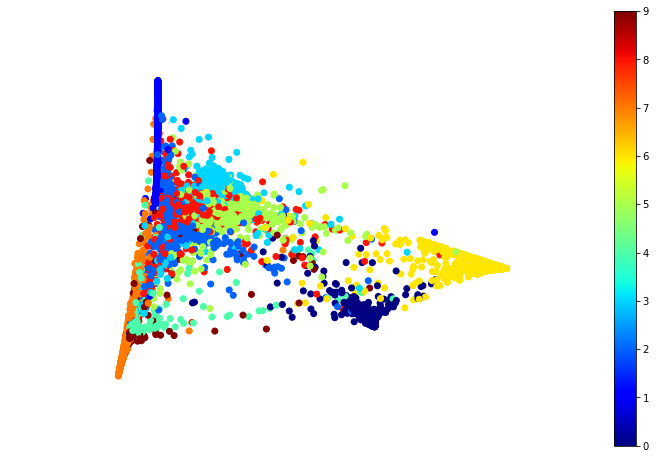

In [27]:
from sklearn.manifold import LocallyLinearEmbedding
t0 = time.time()
X_lle = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print(t1 - t0)

plt.figure(figsize=(12, 8))
plt.scatter(X_lle[:,0], X_lle[:,1], c = y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

It took a while, and also, the visualization is not at all appealing. 

let's now chain this with PCA

**PCA + LLE**

63.01653432846069


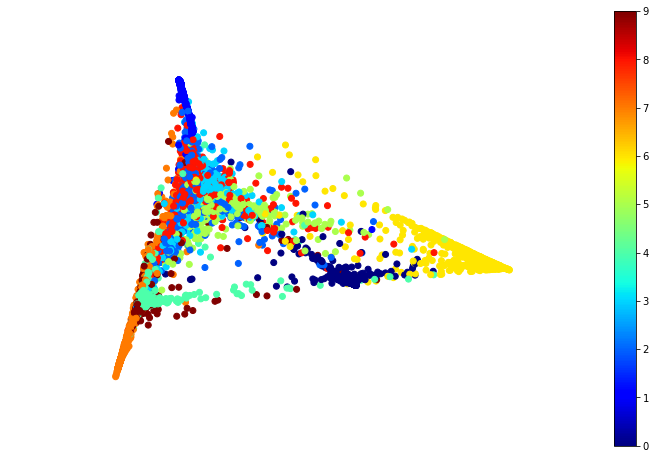

In [28]:
pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle = pca_lle.fit_transform(X)
t1 = time.time()
print(t1-t0)

plt.figure(figsize=(12, 8))
plt.scatter(X_pca_lle[:,0], X_pca_lle[:,1], c = y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

Well, while the results were same, the time was quite reduced. That's what we had expected!

Let's try a last one! LDA

**LDA: Linear Discriminant Analysis**

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


2.5496580600738525


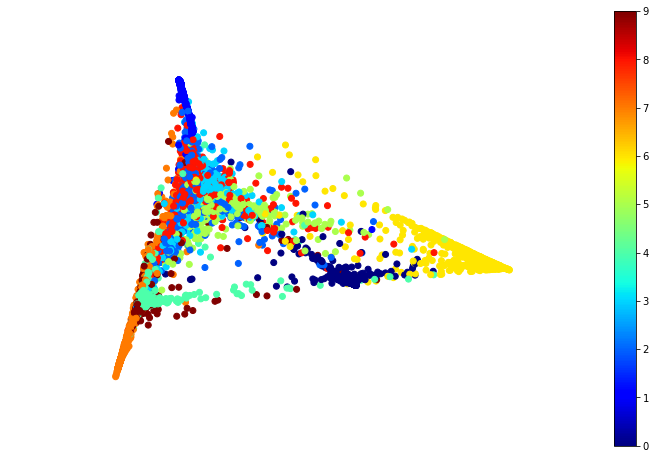

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print(t1 - t0)

plt.figure(figsize=(12, 8))
plt.scatter(X_pca_lle[:,0], X_pca_lle[:,1], c = y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

Wow! this was quite faster! Although the clusturs are still not that great!

**That's all! We have tried exploring various Dimensionality Reduction Algorithms and seen how they perform. 
And I guess, We have a clear Winner here, yes..that's TSNE !! It was faster when chained with PCA and the results as well were quite better than others.**

**Findings:** 
1. TSNE out-performed other algorithm at making clear clusters.
2. PCA helped other algorithms to perform faster reduction.
3. PCA scales faster than other algorithms but is not that good in creating clusters.
4. Manifold based algorithms scale very poorly with larger dataset, hence are very slow.

**Conclusions:**
1. Manifold based reduction methods scale very poorly with larger dataset, hence are very slow.
2. Chaining PCA with Manifold based reduction methods can help them scale faster.

------------------------------------------------------------------------------------------
*That's all folks! :)*

*Thanks*